<a href="https://colab.research.google.com/github/nickskywolf/CodeCrafters/blob/main/HW_4_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [8]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# Завантаження даних
df = pd.read_csv('bikes_rent.csv')

# Виведення перших 5 рядків даних
print(df.head())

   season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed(mph)  windspeed(ms)   cnt  
0  18.18125  80.5833       10.749882       4.805490   985  
1  17.68695  69.6087       16.652113       7.443949   801  
2   9.47025  43.7273       16.636703       7.437060  1349  
3  10.60610  59.0435       10.739832       4.800998  1562  
4  11.46350  43.6957       12.522300       5.597810  1600  


Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

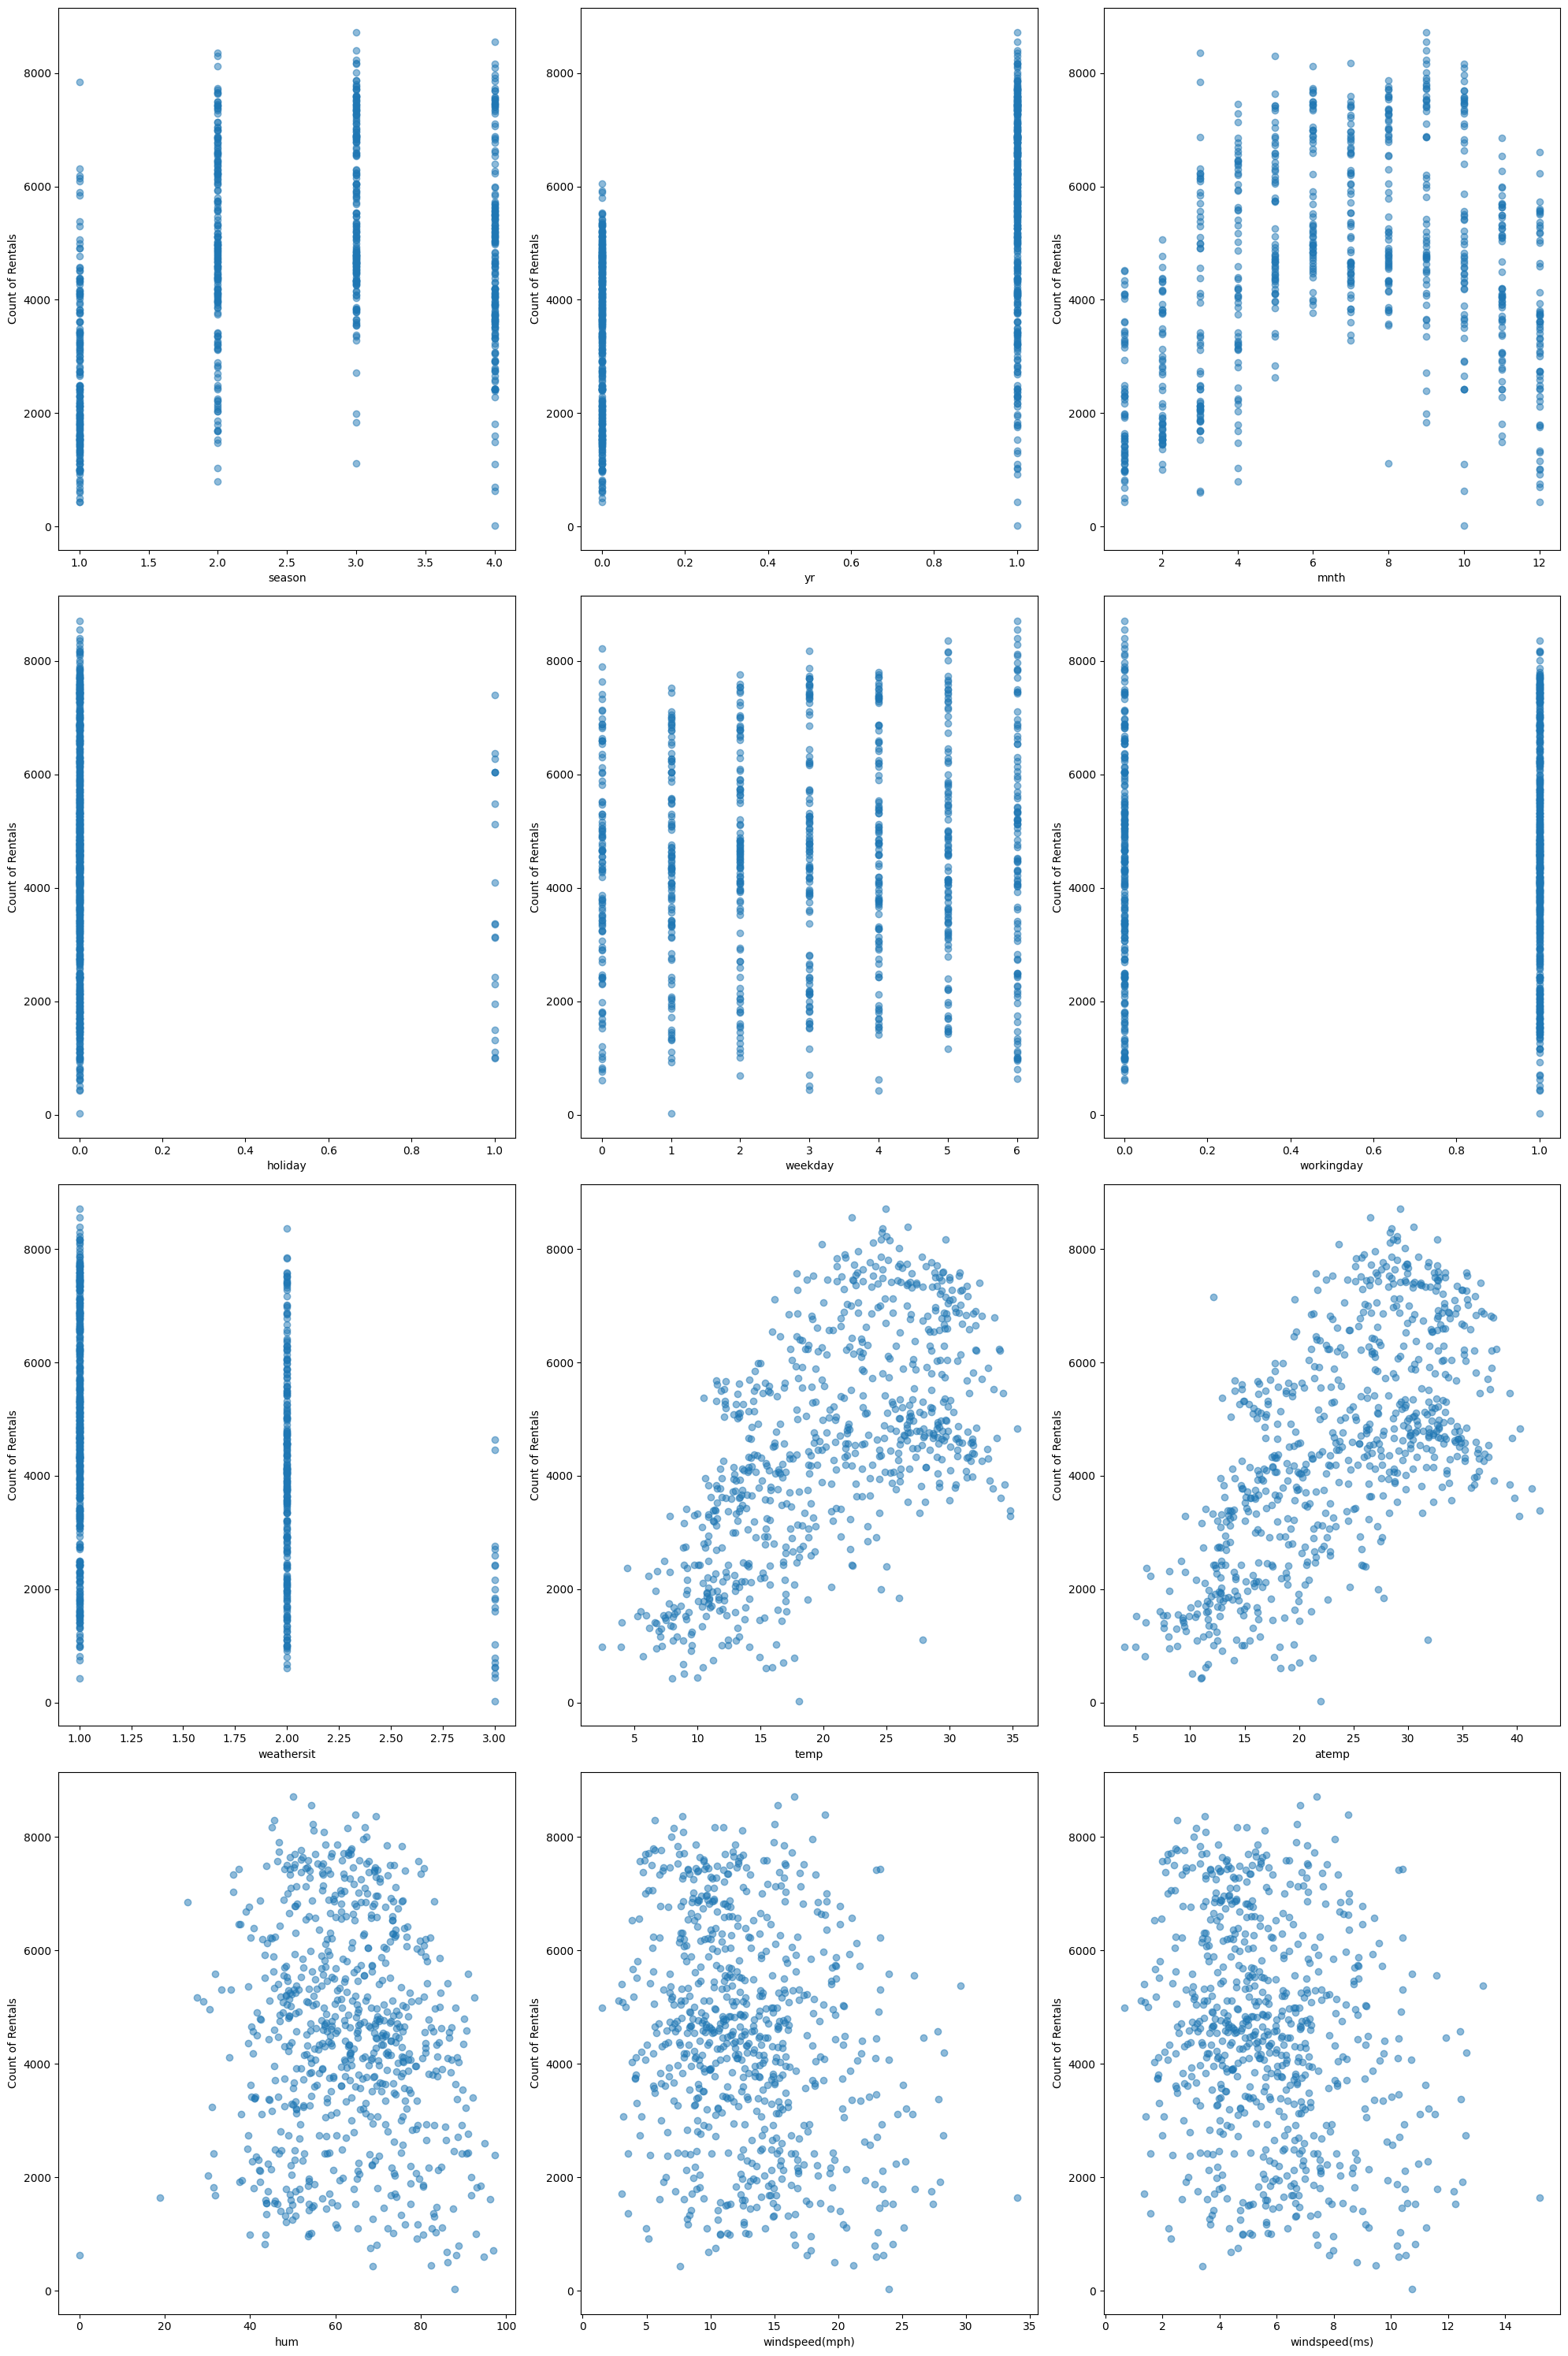

In [9]:
# Побудова графіків залежностей атрибутів від кількості поїздок
attributes = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']
plt.figure(figsize=(20, 30))

for i, attr in enumerate(attributes, 1):
    plt.subplot(4, 3, i)
    plt.scatter(df[attr], df['cnt'], alpha=0.5)
    plt.xlabel(attr)
    plt.ylabel('Count of Rentals')

plt.tight_layout()
plt.show()


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

In [ ]:
# Put you code here

NameError: name 'pd' is not defined

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [10]:
# Розрахунок кореляцій між ознаками і цільовою змінною
correlations = df.iloc[:, :-1].corrwith(df['cnt'])

# Виведення кореляцій
print(correlations)

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64


In [11]:
# Розрахунок кореляцій між речовими ознаками
numeric_attributes = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']
numeric_correlations = df[numeric_attributes].corr()

# Виведення кореляцій між речовими ознаками
print(numeric_correlations)


                    temp     atemp       hum  windspeed(mph)  windspeed(ms)
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000


In [12]:
# Розрахунок кореляцій між ознаками і цільовою змінною
correlations = df.iloc[:, :-1].corrwith(df['cnt'])

# Виведення кореляцій
print(correlations)


season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64


In [13]:
# Розрахунок кореляцій між речовими ознаками
numeric_attributes = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']
numeric_correlations = df[numeric_attributes].corr()

# Виведення кореляцій між речовими ознаками
print(numeric_correlations)


                    temp     atemp       hum  windspeed(mph)  windspeed(ms)
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000


У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [14]:
# Розрахунок попарних кореляцій
pairwise_correlations = df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr()

# Виведення попарних кореляцій
print(pairwise_correlations)


                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [18]:
# Виведення середніх значень ознак
print(df.mean())

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [16]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [17]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [19]:
from sklearn.linear_model import LinearRegression

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [20]:
# Створення об'єкта лінійного регресора
regressor = LinearRegression()

# Навчання моделі на всіх даних
regressor.fit(df.drop(columns=['cnt']), df['cnt'])

# Виведення ваг моделі
print("Weights of the model:")
for feature, weight in zip(df.columns[:-1], regressor.coef_):
    print(f"{feature}: {weight}")

Weights of the model:
season: 514.2756689772416
yr: 2043.9333206099773
mnth: -40.96317631503962
holiday: -519.3860417173415
weekday: 68.49569506058863
workingday: 121.29281595858514
weathersit: -606.4542679476724
temp: 48.994172947818015
atemp: 71.9163310082323
hum: -10.230641893838651
windspeed(mph): 2400995993962.544
windspeed(ms): -5371028038579.01


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [22]:
from sklearn.linear_model import Lasso, Ridge

# Навчання моделі Lasso з L1-регуляризацією
lasso_regressor = Lasso()
lasso_regressor.fit(df.drop(columns=['cnt']), df['cnt'])

# Виведення ваг моделі Lasso
print("Weights of the Lasso model:")
for feature, weight in zip(df.columns[:-1], lasso_regressor.coef_):
    print(f"{feature}: {weight}")

Weights of the Lasso model:
season: 506.5512786498074
yr: 2036.2316676979037
mnth: -38.07827028932167
holiday: -484.65194618654056
weekday: 68.93837479133958
workingday: 118.4475975866837
weathersit: -604.5667118927049
temp: 51.363260585616366
atemp: 69.91273749012187
hum: -10.352705204636573
windspeed(mph): -38.34106761310847
windspeed(ms): -0.0


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [23]:
ridge_regressor = Ridge()
ridge_regressor.fit(df.drop(columns=['cnt']), df['cnt'])

# Виведення ваг моделі Ridge
print("\nWeights of the Ridge model:")
for feature, weight in zip(df.columns[:-1], ridge_regressor.coef_):
    print(f"{feature}: {weight}")


Weights of the Ridge model:
season: 507.8018818505763
yr: 2029.0890541970502
mnth: -38.470897279124635
holiday: -493.2780154838191
weekday: 69.11396965165964
workingday: 121.5244250292943
weathersit: -605.205555373153
temp: 49.31676759598743
atemp: 71.7859872733456
hum: -10.383394500484615
windspeed(mph): -31.93550169428455
windspeed(ms): -14.276040263842843


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [25]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    lasso_regressor = Lasso(alpha=alpha)
    lasso_regressor.fit(df.drop(columns=['cnt']), df['cnt'])
    coefs_lasso.append(lasso_regressor.coef_)

    ridge_regressor = Ridge(alpha=alpha)
    ridge_regressor.fit(df.drop(columns=['cnt']), df['cnt'])
    coefs_ridge.append(ridge_regressor.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

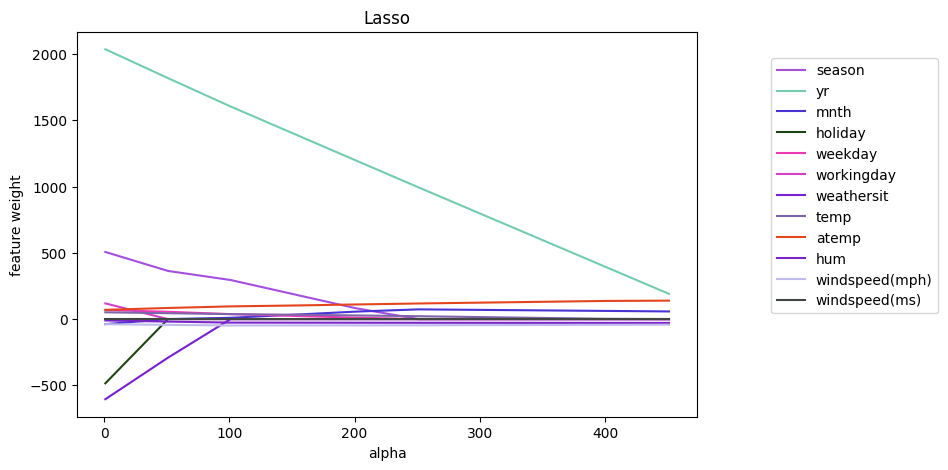

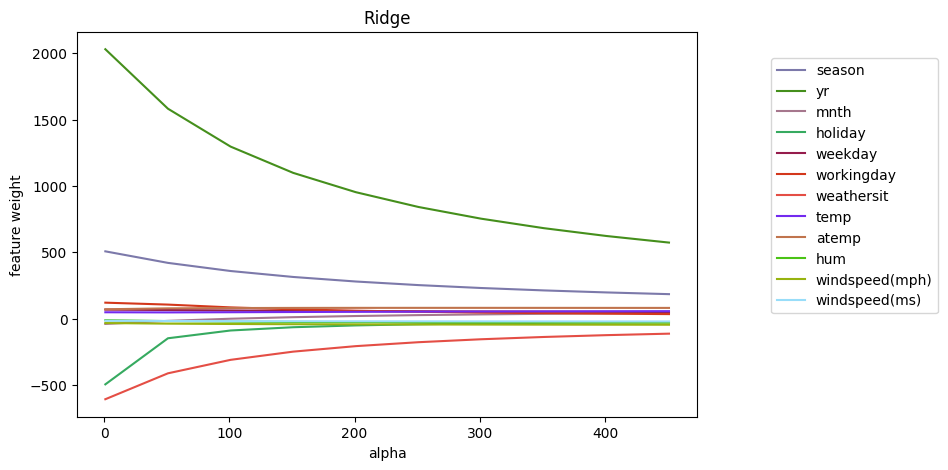

In [26]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?



Lasso агресивніше зменшує ваги при одному й тому самому alpha. Це видно з того, що ваги при Lasso швидше зближаються до нуля при збільшенні alpha.
Якщо alpha стає дуже великим для Lasso, то всі ваги вкрай зменшаться і збілися до нуля. Це відбувається через те, що великий alpha викликає сильну регуляризацію, що призводить до того, що штраф за великі значення ваг стає настільки великим, що краще зменшити ваги до нуля, ніж платити високу ціну за їх великість.
Так, Lasso виключає одну з ознак windspeed при будь-якому значенні alpha > 0, оскільки вага при цій ознаці стає меншою за 10^-3. Для Ridge це не відбувається, оскільки ваги при ознаках не зменшуються до нуля так швидко, як у випадку Lasso.
Lasso більш підходить для відбору неінформативних ознак, оскільки він здатний виключати ознаки, які не впливають на цільову змінну, швидше, ніж Ridge.

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [43]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))  # Перетворюємо генератор у список
    y = list(map(lambda e: e[1], data))  # Перетворюємо генератор у список
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()


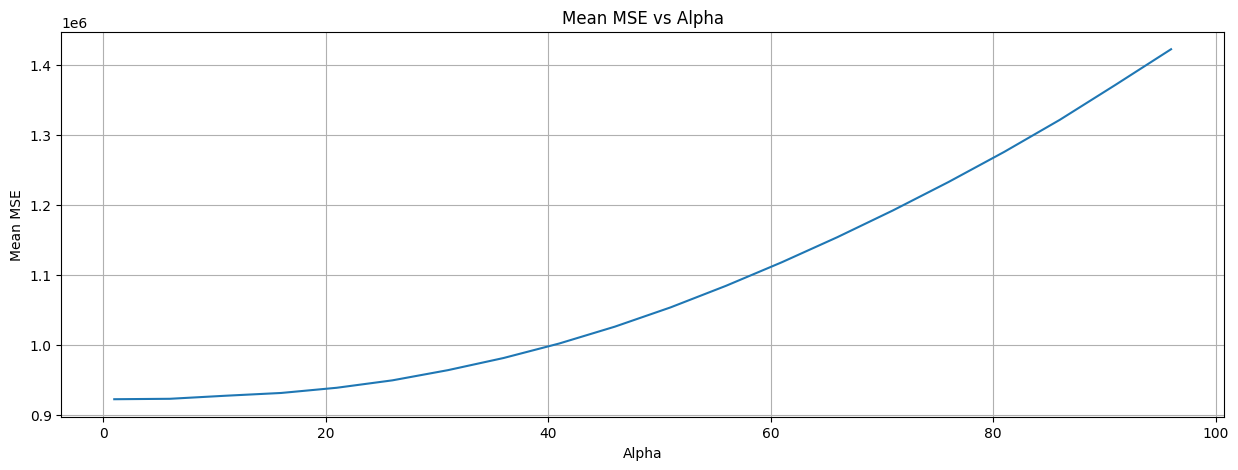

Selected alpha: 1
('season', 506.5512786498074)
('yr', 2036.2316676979037)
('mnth', -38.07827028932167)
('holiday', -484.65194618654056)
('weekday', 68.93837479133958)
('workingday', 118.4475975866837)
('weathersit', -604.5667118927049)
('temp', 51.363260585616366)
('atemp', 69.91273749012187)
('hum', -10.352705204636573)
('windspeed(mph)', -38.34106761310847)
('windspeed(ms)', -0.0)


In [44]:
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

# Навчіть регресор LassoCV на всіх параметрах регуляризації з alpha
regressor = LassoCV(alphas=alphas, cv=3)
regressor.fit(df.drop(columns=['cnt']), df['cnt'])

# Побудуйте графік усередненого за рядками MSE в залежності від alpha
create_plot(list(zip(regressor.alphas_, np.mean(regressor.mse_path_, axis=1))),
            title='Mean MSE vs Alpha', xlabel='Alpha', ylabel='Mean MSE')


# Виведіть вибране alpha
print("Selected alpha:", regressor.alpha_)

# Виведіть пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів
feature_coef_pairs = zip(df.columns, regressor.coef_)
for pair in feature_coef_pairs:
    print(pair)


Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


Alphas with minimum MSE:
Alpha = 1, MSE = 783221.2007323484
Alpha = 51, MSE = 606705.6506735483
Alpha = 1, MSE = 1234577.1775608219


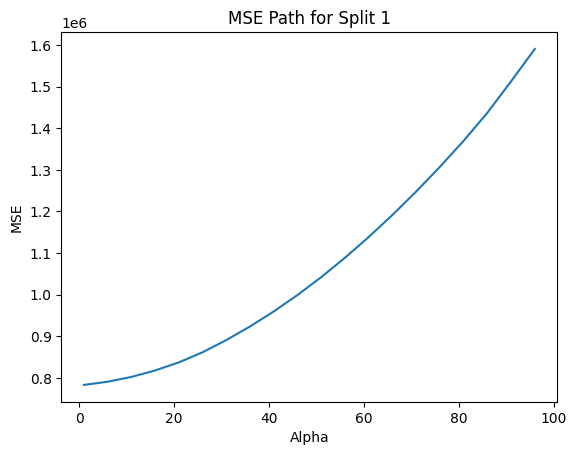

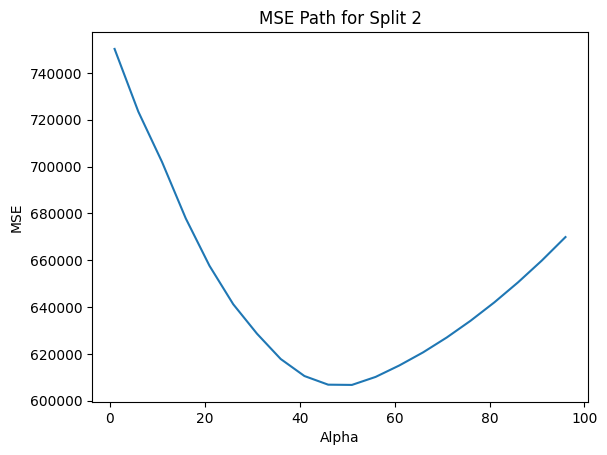

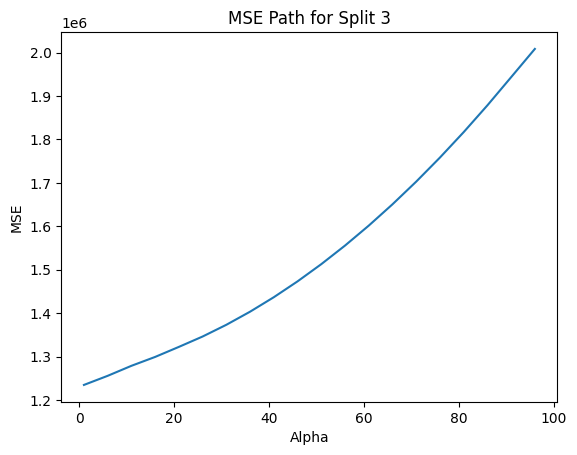

In [45]:
# Знайти індекси мінімальних значень MSE для кожного розбиття
min_indices = np.argmin(regressor.mse_path_, axis=0)

# Вивести значення alpha, що відповідають мінімумам MSE на кожному розбитті
print("Alphas with minimum MSE:")
for i, idx in enumerate(min_indices):
    alpha = regressor.alphas_[idx]
    mse = regressor.mse_path_[idx, i]
    print(f"Alpha = {alpha}, MSE = {mse}")

# Побудувати графіки для стовпців mse_path_ для кожного розбиття
for i, idx in enumerate(min_indices):
    plt.plot(regressor.alphas_, regressor.mse_path_[:, i])
    plt.title(f"MSE Path for Split {i+1}")
    plt.xlabel("Alpha")
    plt.ylabel("MSE")
    plt.show()


На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__

Top 4 features with highest positive coefficients:
yr
season
workingday
atemp


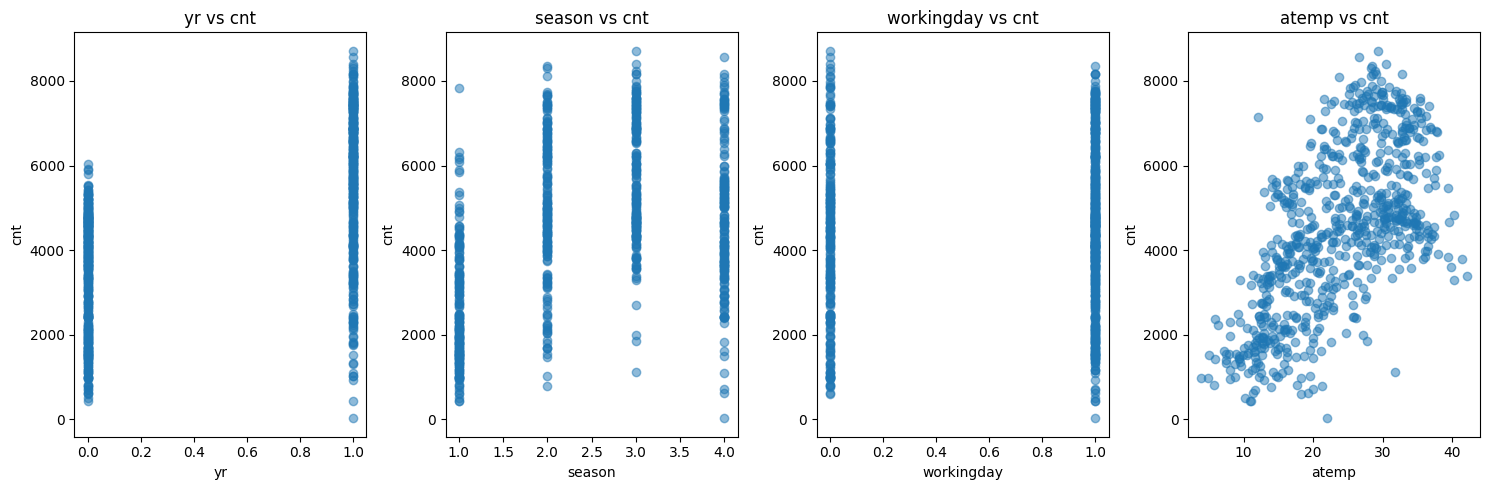

Запитання 1:
На графіках видно зростаючу лінійну залежність cnt від ознак з найбільшими позитивними коефіцієнтами.
Логічно стверджувати, що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди.


In [46]:
# Запитання 1
# Виберемо 4 ознаки з найбільшими позитивними коефіцієнтами
top_positive_features = sorted(zip(df.columns, regressor.coef_), key=lambda x: -x[1])[:4]
print("Top 4 features with highest positive coefficients:")
for feature, coef in top_positive_features:
    print(feature)

# Відобразимо графіки залежностей cnt від цих ознак
plt.figure(figsize=(15, 5))
for i, (feature, coef) in enumerate(top_positive_features, 1):
    plt.subplot(1, 4, i)
    plt.scatter(df[feature], df['cnt'], alpha=0.5)
    plt.title(f'{feature} vs cnt')
    plt.xlabel(feature)
    plt.ylabel('cnt')
plt.tight_layout()
plt.show()

# Відповідь на запитання 1
print("Запитання 1:")
print("На графіках видно зростаючу лінійну залежність cnt від ознак з найбільшими позитивними коефіцієнтами.")
print("Логічно стверджувати, що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди.")

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__


Top 3 features with highest absolute negative coefficients:
weathersit
holiday
windspeed(mph)


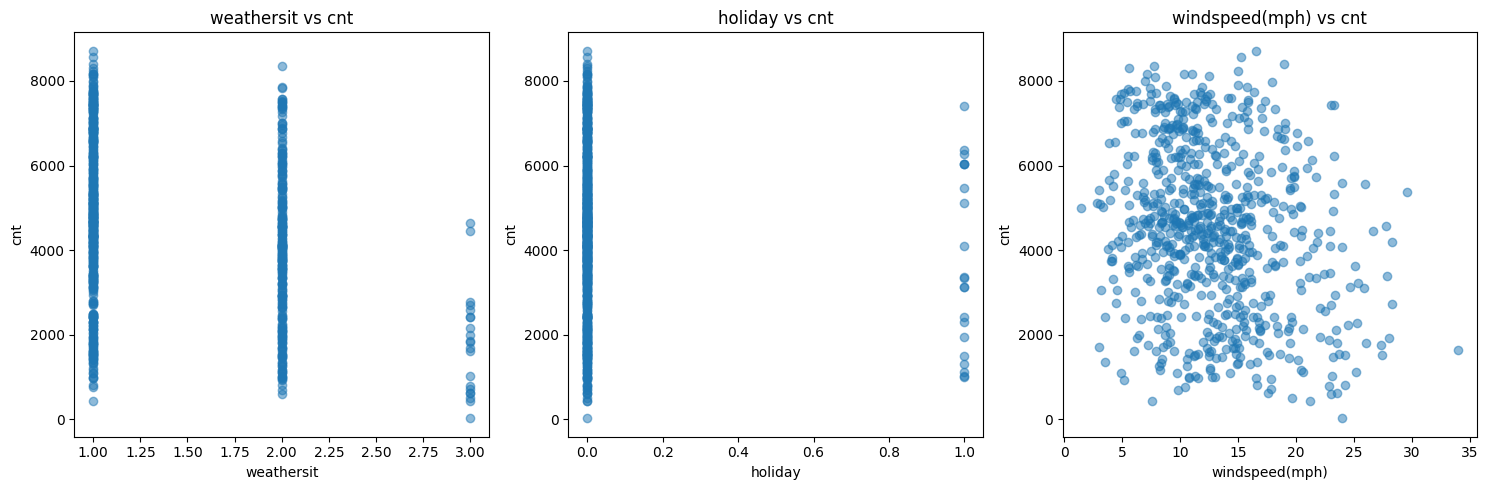

Запитання 2:
На графіках видно зменшувальну лінійну залежність cnt від ознак з найбільшими за модулем негативними коефіцієнтами.
Логічно стверджувати, що чим більше значення цих ознак, тим менше людей захочуть взяти велосипеди.


In [47]:
top_negative_features = sorted(zip(df.columns, regressor.coef_), key=lambda x: x[1])[:3]
print("\nTop 3 features with highest absolute negative coefficients:")
for feature, coef in top_negative_features:
    print(feature)

# Відобразимо графіки залежностей cnt від цих ознак
plt.figure(figsize=(15, 5))
for i, (feature, coef) in enumerate(top_negative_features, 1):
    plt.subplot(1, 3, i)
    plt.scatter(df[feature], df['cnt'], alpha=0.5)
    plt.title(f'{feature} vs cnt')
    plt.xlabel(feature)
    plt.ylabel('cnt')
plt.tight_layout()
plt.show()

# Відповідь на запитання 2
print("Запитання 2:")
print("На графіках видно зменшувальну лінійну залежність cnt від ознак з найбільшими за модулем негативними коефіцієнтами.")
print("Логічно стверджувати, що чим більше значення цих ознак, тим менше людей захочуть взяти велосипеди.")

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

In [48]:
near_zero_features = [(feature, coef) for feature, coef in zip(df.columns, regressor.coef_) if abs(coef) < 1e-3]
print("\nFeatures with coefficients close to zero:")
for feature, coef in near_zero_features:
    print(f"{feature}: {coef}")

# Відповідь на запитання 3
print("Запитання 3:")
print("Модель виключила ознаки з коефіцієнтами, близькими до нуля, оскільки вони не впливають на попит на велосипеди.")
print("Це може бути пов'язано з тим, що ці ознаки мають дуже слабкий або навіть відсутній вплив на цільову змінну.")


Features with coefficients close to zero:
windspeed(ms): -0.0
Запитання 3:
Модель виключила ознаки з коефіцієнтами, близькими до нуля, оскільки вони не впливають на попит на велосипеди.
Це може бути пов'язано з тим, що ці ознаки мають дуже слабкий або навіть відсутній вплив на цільову змінну.


### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.